In [1]:
# Install RAPIDS (takes ~10 min).
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

# https://github.com/NVIDIA/NVTabular/blob/main/examples/winning-solution-recsys2020-twitter/01-02-04-Download-Convert-ETL-with-NVTabular-Training-with-XGBoost.ipynb     

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 205 (delta 16), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (205/205), 62.72 KiB | 8.96 MiB/s, done.
Resolving deltas: 100% (78/78), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals(

In [2]:
# Needed to fix conda and install nvtabular.
!conda install https://repo.anaconda.com/pkgs/main/linux-64/conda-4.9.2-py37h06a4308_0.tar.bz2
!pip install git+https://github.com/NVIDIA/NVTabular.git@main


conda-4.9.2          | : 100% 1.0/1 [00:00<00:00,  1.08it/s]
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done
  Cloning https://github.com/NVIDIA/NVTabular.git (to revision main) to /tmp/pip-req-build-9necjo61
  Running command git clone -q https://github.com/NVIDIA/NVTabular.git /tmp/pip-req-build-9necjo61
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nvtabular: filename=nvtabular-0.4.0+19.gdd1c8b6-py3-none-any.whl size=206846 sha256=63d3369bb3ed263b42ad3c3cbace7fbbe117c374ea5323b996adc5a2caf06cfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-y10sx0o0/wheels/32/74/7c/e2d323de42120f4cefc10fb3fe2543f6c7558bf7c7b3a021c5
Successfully built nvtabular


In [ ]:
# For rapidsai 0.19 ONLY, not working.
"""
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test

!sudo apt-get update

!sudo apt-get install gcc-4.9

!sudo apt-get upgrade libstdc++6
!sudo apt-get dist-upgrade
!strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX"""

In [3]:
# External Dependencies
import time
import glob
import gc

import cupy as cp          # CuPy is an implementation of NumPy-compatible multi-dimensional array on GPU
import cudf                # cuDF is an implementation of Pandas-like Dataframe on GPU
import rmm                 # library for pre-allocating memory on GPU
import dask                # dask is an open-source library to nateively scale Python on multiple workers/nodes
import dask_cudf           # dask_cudf uses dask to scale cuDF dataframes on multiple workers/nodes

import numpy as np
# NVTabular is the core library, we will use here for feature engineering/preprocessing on GPU
import nvtabular as nvt
import xgboost as xgb

# More dask / dask_cluster related libraries to scale NVTabular
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask.distributed import wait
from dask.utils import parse_bytes
from dask.delayed import delayed
from nvtabular.utils import device_mem_size
from nvtabular.column_group import ColumnGroup

In [ ]:
!nvidia-smi

Mon Apr  5 20:57:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
time_total_start = time.time()

In [5]:
# Assume dataset in MyDrive/RecSys2021
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/RecSys2021/'

Mounted at /content/drive


In [6]:
cluster = LocalCUDACluster(
    protocol="tcp"
)
client = Client(cluster)
client

/usr/local/lib/python3.7/site-packages/distributed/client.py:1140: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:38611 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 12.72 GiB


In [7]:
# Preparing our dataset

features = [
    'text_tokens',    ###############
    'hashtags',       #Tweet Features
    'tweet_id',       #
    'media',          #
    'links',          #
    'domains',        #
    'tweet_type',     #
    'language',       #
    'timestamp',      ###############
    'a_user_id',              ###########################
    'a_follower_count',       #Engaged With User Features
    'a_following_count',      #
    'a_is_verified',          #
    'a_account_creation',     ###########################
    'b_user_id',              #######################
    'b_follower_count',       #Engaging User Features
    'b_following_count',      #
    'b_is_verified',          #
    'b_account_creation',     #######################
    'b_follows_a',    #################### Engagement Features
    'reply',          #Target Reply
    'retweet',        #Target Retweet    
    'retweet_comment',#Target Retweet with comment
    'like',           #Target Like
                      ####################
]

In [8]:
# Splits the entries in media by \t and keeps only the first two values (if available).
def splitmedia(col):
    if col.shape[0] == 0:
        return(col)
    else:
        return(col) 
        return(col.str.split('\t', expand=True)[0].fillna('') + '_' + col.str.split('\t', expand=True)[1].fillna(''))

# Counts the number of token in a column (e.g. how many hashtags are in a tweet).  
def count_token(col,token):
    not_null = col.isnull()==0
    return ((col.str.count(token)+1)*not_null).fillna(0)

In [9]:
# >> is an overloaded operator, it transforms columns in other columns applying functions to them.
count_features = (
    nvt.ColumnGroup(['hashtags', 'domains', 'links']) >> (lambda col: count_token(col,'\t')) >> nvt.ops.Rename(postfix = '_count_t')
)

split_media = nvt.ColumnGroup(['media']) >> (lambda col: splitmedia(col))

# Encode categorical columns as a small, continuous integer to save memory.
# Before we can apply Categorify, we need to fill na/missing values in the columns hashtags, domains and links.
multihot_filled = ['hashtags', 'domains', 'links'] >> nvt.ops.FillMissing()
cat_features = (
    split_media + multihot_filled + ['language', 'tweet_type', 'tweet_id', 'a_user_id', 'b_user_id'] >> 
    nvt.ops.Categorify()
)

label_name = ['reply', 'retweet', 'retweet_comment', 'like']
label_name_feature = label_name >> nvt.ops.FillMissing()

weekday = (
    nvt.ColumnGroup(['timestamp']) >> 
    (lambda col: cudf.to_datetime(col, unit='s').dt.weekday) >> 
    nvt.ops.Rename(postfix = '_wd')
)

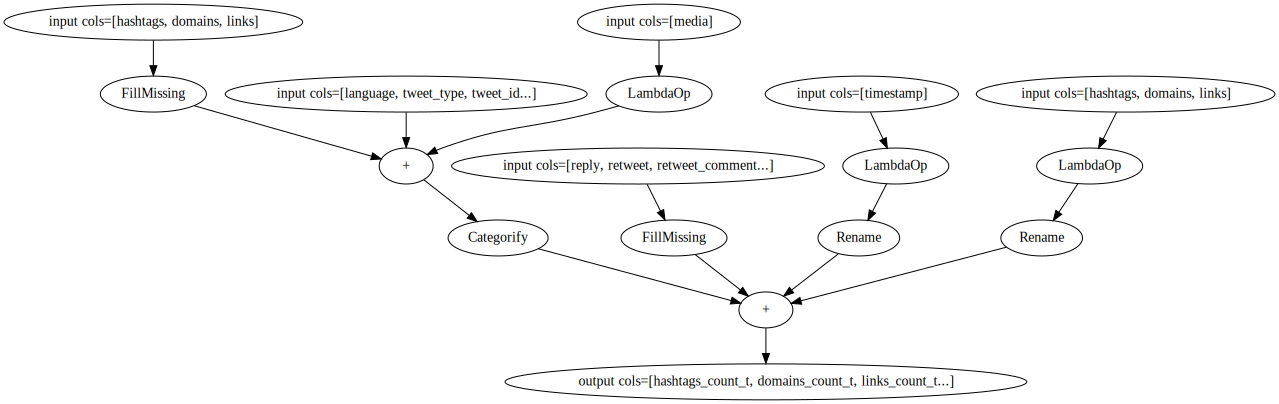

In [10]:
output = count_features+cat_features+label_name_feature+weekday
(output).graph

In [11]:
remaining_columns = [x for x in features if x not in (output.columns+['text_tokens'])]
remaining_columns

['timestamp',
 'a_follower_count',
 'a_following_count',
 'a_is_verified',
 'a_account_creation',
 'b_follower_count',
 'b_following_count',
 'b_is_verified',
 'b_account_creation',
 'b_follows_a']

In [12]:
proc = nvt.Workflow(output+remaining_columns)

In [13]:
data_parts = []
for file in os.listdir(BASE_DIR):
    if file.endswith(".tsv"):
        data_parts.append(os.path.join(BASE_DIR, file))

trains_itrs = nvt.Dataset(data_parts, 
                          header=None, 
                          names=features, 
                          engine='csv', 
                          sep='\x01', 
                          part_size='2GB')

In [14]:
client = Client(cluster)  # Sample client connecting to `cluster` object
# client.run(cudf.set_allocator, "managed")  # Uses managed memory instead of "default"
import torch, gc
gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/site-packages/distributed/client.py:1140: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [15]:
time_preproc_start = time.time()
proc.fit(trains_itrs)
time_preproc = time.time()-time_preproc_start
time_preproc

160.2908799648285

In [16]:
# We define the output datatypes for continuous columns to save memory. We can define the output datatypes as a dict and parse it to the to_parquet function.
dict_dtypes = {}
for col in label_name + ['media', 'language', 'tweet_type', 'tweet_id', 
                         'a_user_id', 'b_user_id', 'hashtags', 'domains', 
                         'links', 'timestamp', 'a_follower_count', 
                         'a_following_count', 'a_account_creation',
                         'b_follower_count', 'b_following_count', 'b_account_creation']:
    dict_dtypes[col] = np.uint32

In [17]:
time_preproc_start = time.time()
proc.transform(trains_itrs).to_parquet(output_path=BASE_DIR + 'preprocess/', dtypes=dict_dtypes)
time_preproc += time.time()-time_preproc_start
time_preproc

240.14241981506348

In [18]:
# Splitting dataset

# We split the training data by time into a train and validation set. The first 5 days are train and the last 2 days are for validation. We use the weekday for it.
# The first day of the dataset is a Thursday (weekday id = 3) and the last day is Wednesday (weekday id = 2) (Not sure for this year).
time_split_start = time.time()

import pandas as pd
df = dask_cudf.read_parquet(BASE_DIR + 'preprocess/*.parquet')
if 'text_tokens' in list(df.columns):
    df = df.drop('text_tokens', axis=1)
VALID_DOW = [1, 2]
# pd.set_option('display.max_rows', 100)
# df.head(100)

valid = df[df['timestamp_wd'].isin(VALID_DOW)].reset_index(drop=True)
train = df[~df['timestamp_wd'].isin(VALID_DOW)].reset_index(drop=True)
train = train.sort_values(["b_user_id", "timestamp"]).reset_index(drop=True)
valid = valid.sort_values(["b_user_id", "timestamp"]).reset_index(drop=True)
train.to_parquet(BASE_DIR + 'nv_train/')
valid.to_parquet(BASE_DIR + 'nv_valid/')
time_split = time.time()-time_split_start
time_split

del train; del valid
gc.collect()

11454

In [19]:
# Feature Engineering

# We count encode the columns media, tweet_type, language, a_user_id, b_user_id.
# For counting encoding info see https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_4_CountEncoding.ipynb
count_encode = (
    ['media', 'tweet_type', 'language', 'a_user_id', 'b_user_id'] >> 
    nvt.ops.JoinGroupby(cont_cols=['reply'],stats=["count"], out_path='./')
)

# We transform timestamp to datetime type and extract hours, minutes, seconds.
datetime = nvt.ColumnGroup(['timestamp']) >> (lambda col: cudf.to_datetime(col.astype('int32'), unit='s'))
hour = datetime >> (lambda col: col.dt.hour) >> nvt.ops.Rename(postfix = '_hour')
minute = datetime >> (lambda col: col.dt.minute) >> nvt.ops.Rename(postfix = '_minute')
seconds = datetime >> (lambda col: col.dt.second) >> nvt.ops.Rename(postfix = '_second')

In [20]:
# We difference encode b_follower_count, b_following_count, language grouped by b_user_id. First, we need to transform the datatype to float32 to prevent overflow/underflow. 
# After DifferenceEncoding, we want to fill NaN values with 0.
# For difference encoding info see https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/05_2_TimeSeries_Differences.ipynb
diff_lag = (
    nvt.ColumnGroup(['b_follower_count','b_following_count','language']) >> 
    (lambda col: col.astype('float32')) >> 
    nvt.ops.DifferenceLag(partition_cols=['b_user_id'], shift = [1, -1]) >> 
    nvt.ops.FillMissing(fill_val=0)
)

In [21]:
# Transform targets in binary labels.
LABEL_COLUMNS = ['reply', 'retweet', 'retweet_comment', 'like'] 
labels = nvt.ColumnGroup(LABEL_COLUMNS) >> (lambda col: (col>0).astype('int8'))

In [22]:
# We apply TargetEncoding with kfold of 5 and smoothing of 20.
# For target encoding info see https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784
# and https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_3_TargetEncoding.ipynb
target_encode = (
    ['media', 'tweet_type', 'language', 'a_user_id', 'b_user_id', 
     ['domains','language','b_follows_a','tweet_type','media','a_is_verified']] >>
    nvt.ops.TargetEncoding(
        labels,
        kfold=5,
        p_smooth=20,
        out_dtype="float32",
    )
)

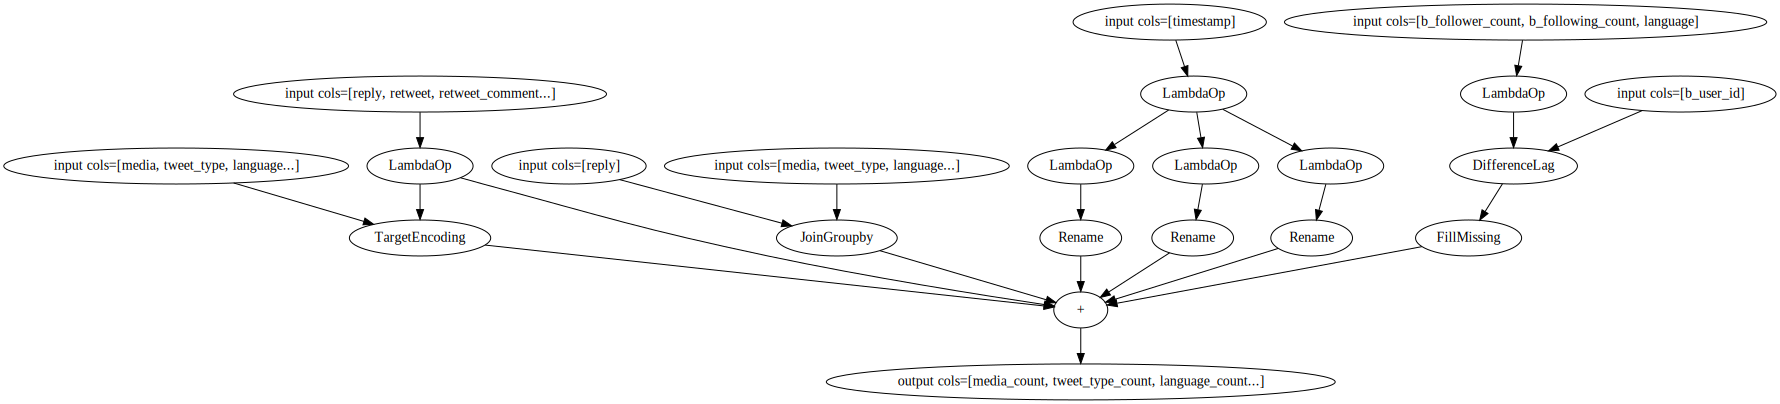

In [23]:
output = count_encode+hour+minute+seconds+diff_lag+labels+target_encode
(output).graph

In [24]:
# We want to keep all columns of the input dataset. Therefore, we extract all column names from the first input parquet file.
df_tmp = cudf.read_parquet(BASE_DIR + '/nv_train/part.0.parquet')
all_input_columns = df_tmp.columns
del df_tmp
gc.collect()

remaining_columns = [x for x in all_input_columns if x not in (output.columns+['text_tokens'])]
remaining_columns

# We initialize our NVTabular workflow and add the "remaining" columns to it.
proc = nvt.Workflow(output+remaining_columns)

# We initialize the train and valid as NVTabular datasets.
train_dataset = nvt.Dataset(glob.glob(BASE_DIR + 'nv_train/*.parquet'), 
                            engine='parquet', 
                            part_size="2GB")
valid_dataset = nvt.Dataset(glob.glob(BASE_DIR + 'nv_valid/*.parquet'), 
                            engine='parquet', 
                            part_size="2GB")

In [25]:
time_fe_start = time.time()
proc.fit(train_dataset)
time_fe = time.time()-time_fe_start
time_fe

23.267625093460083

In [26]:
# The columns a_is_verified, b_is_verified and b_follows_a have the datatype boolean. 
# XGBoost does not support boolean datatypes and we need convert them to int8. We can define the output datatypes as a dict and parse it to the .to_parquet function.
dict_dtypes = {}
for col in ['a_is_verified','b_is_verified','b_follows_a']:
    dict_dtypes[col] = np.int8

# We apply the transformation to the train and valid datasets.
time_fe_start = time.time()
proc.transform(train_dataset).to_parquet(output_path=BASE_DIR + 'nv_train_fe/', dtypes=dict_dtypes)
proc.transform(valid_dataset).to_parquet(output_path=BASE_DIR + 'nv_valid_fe/', dtypes=dict_dtypes)
time_fe += time.time()-time_fe_start
time_fe

54.570754528045654

In [27]:
# Training

train = dask_cudf.read_parquet(BASE_DIR + 'nv_train_fe/*.parquet')
valid = dask_cudf.read_parquet(BASE_DIR + 'nv_valid_fe/*.parquet')
train[['a_is_verified','b_is_verified','b_follows_a']].dtypes

# Some columns are only used for feature engineering. Therefore, we define the columns we want to ignore for training.
dont_use =[
    '__null_dask_index__',
    'text_tokens',
    'timestamp',
    'a_account_creation',
    'b_account_creation',
    'hashtags',
    'tweet_id',
    'links',
    'domains',
    'a_user_id',
    'b_user_id',
    'timestamp_wd',
    'timestamp_to_datetime',
    'a_following_count_a_ff_rate',
    'b_following_count_b_ff_rate'
]
dont_use = [x for x in train.columns if x in dont_use]
label_names = ['reply', 'retweet', 'retweet_comment', 'like']

In [28]:
# Nvidia experiments show that we require only 10% of the training dataset. Our feature engineering, such as TargetEncoding,
# uses the training datasets and leverage the information of the full dataset.
# In the competition, Nvidia trained the models with higher ratio (20% and 50%), but could not observe an improvement in performance.
# Since I'm using only a small part of the dataset, I will use all of it.
SAMPLE_RATIO = 0.999  # 0.1 
SEED = 1

if SAMPLE_RATIO < 1.0:
    train['sample'] = train['tweet_id'].map_partitions(lambda cudf_df: cudf_df.hash_encode(stop=10))
    print(len(train))
    
    train = train[train['sample']<10*SAMPLE_RATIO]
    train, = dask.persist(train)
    print(len(train))


Y_train = train[label_names]
Y_train, = dask.persist(Y_train)    
    
train = train.drop(['sample']+label_names+dont_use,axis=1)
train, = dask.persist(train)

print('Using %i features'%(train.shape[1]))

6431311
6431311
Using 51 features


In [29]:
# Similar to the training dataset, Nvidia experiments show that 35% of our validation dataset is enough to get a good estimate of the performance metric. 
# 35% of the validation dataset has a similar size as the test set of the RecSys2020 competition.
SAMPLE_RATIO = 0.999  # 0.35
SEED = 1
if SAMPLE_RATIO < 1.0:
    print(len(valid))
    valid['sample'] = valid['tweet_id'].map_partitions(lambda cudf_df: cudf_df.hash_encode(stop=10))
    
    valid = valid[valid['sample']<10*SAMPLE_RATIO]
    valid, = dask.persist(valid)
    print(len(valid))
    
Y_valid = valid[label_names]
Y_valid, = dask.persist(Y_valid)

valid = valid.drop(['sample']+label_names+dont_use,axis=1)
valid, = dask.persist(valid)

2625000
2625000


In [30]:
# We initialize our XGBoost parameter.
print('XGB Version',xgb.__version__)

xgb_parms = { 
    'max_depth':8, 
    'learning_rate':0.1, 
    'subsample':0.8,
    'colsample_bytree':0.3, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor' : 'gpu_predictor'
}

train,valid = dask.persist(train,valid)

XGB Version 1.3.3


In [31]:
# We train our XGBoost models. The challenge requires to predict 4 targets, does a user
# _ like a tweet
# _ reply a tweet
# _ comment a tweet
# _ comment and reply a tweet
# We train 4x XGBoost models for 300 rounds on a GPU.

time_train_start = time.time()

NROUND = 300
VERBOSE_EVAL = 50    
preds = []
for i in range(4):

    name = label_names[i]
    print('#'*25);print('###',name);print('#'*25)
       
    start = time.time(); print('Creating DMatrix...')
    dtrain = xgb.dask.DaskDMatrix(client,data=train,label=Y_train.iloc[:, i])
    print('Took %.1f seconds'%(time.time()-start))
             
    start = time.time(); print('Training...')
    model = xgb.dask.train(client, xgb_parms, 
                           dtrain=dtrain,
                           num_boost_round=NROUND,
                           verbose_eval=VERBOSE_EVAL) 
    print('Took %.1f seconds'%(time.time()-start))
        
    start = time.time(); print('Predicting...')
    preds.append(xgb.dask.predict(client,model,valid))
    print('Took %.1f seconds'%(time.time()-start))
        
    del model, dtrain

time_train = time.time()-time_train_start
time_train

#########################
### reply
#########################
Creating DMatrix...
Took 0.1 seconds
Training...
Took 96.8 seconds
Predicting...


/usr/local/lib/python3.7/site-packages/distributed/worker.py:3569: UserWarning: Large object of size 7.11 MiB detected in task graph: 
  [<function _predict_async.<locals>.mapped_predict  ... titions>, True]
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


Took 1.6 seconds
#########################
### retweet
#########################
Creating DMatrix...
Took 0.1 seconds
Training...
Took 97.3 seconds
Predicting...
Took 1.6 seconds
#########################
### retweet_comment
#########################
Creating DMatrix...
Took 0.1 seconds
Training...
Took 92.6 seconds
Predicting...
Took 1.3 seconds
#########################
### like
#########################
Creating DMatrix...
Took 0.1 seconds
Training...
Took 103.4 seconds
Predicting...
Took 1.7 seconds


396.71082067489624

In [32]:
yvalid = Y_valid[label_names].values.compute()
oof = cp.array([i.values.compute() for i in preds]).T
yvalid.shape

(2625000, 4)

In [33]:
# The hosts of the RecSys2020 competition provide code for calculating the performance metric PRAUC and RCE.
# Nvidia optimized the code to speed up the calculation, as well. Using cuDF / cupy, we can calculate the performance metric on the GPU.
from sklearn.metrics import auc

def precision_recall_curve(y_true,y_pred):
    y_true = y_true.astype('float32')
    ids = cp.argsort(-y_pred) 
    y_true = y_true[ids]
    y_pred = y_pred[ids]
    y_pred = cp.flip(y_pred,axis=0)

    acc_one = cp.cumsum(y_true)
    sum_one = cp.sum(y_true)
    
    precision = cp.flip(acc_one/cp.cumsum(cp.ones(len(y_true))),axis=0)
    precision[:-1] = precision[1:]
    precision[-1] = 1.

    recall = cp.flip(acc_one/sum_one,axis=0)
    recall[:-1] = recall[1:]
    recall[-1] = 0
    n = (recall==1).sum()
    
    return precision[n-1:],recall[n-1:],y_pred[n:]

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    recall, prec = cp.asnumpy(recall), cp.asnumpy(prec)

    prauc = auc(recall, prec)
    return prauc

def log_loss(y_true,y_pred,eps=1e-7, normalize=True, sample_weight=None):
    y_true = y_true.astype('int32')
    y_pred = cp.clip(y_pred, eps, 1 - eps)
    if y_pred.ndim == 1:
        y_pred = cp.expand_dims(y_pred, axis=1)
    if y_pred.shape[1] == 1:
        y_pred = cp.hstack([1 - y_pred, y_pred])

    y_pred /= cp.sum(y_pred, axis=1, keepdims=True)
    loss = -cp.log(y_pred)[cp.arange(y_pred.shape[0]), y_true]
    return _weighted_sum(loss, sample_weight, normalize).item()

def _weighted_sum(sample_score, sample_weight, normalize):
    if normalize:
        return cp.average(sample_score, weights=sample_weight)
    elif sample_weight is not None:
        return cp.dot(sample_score, sample_weight)
    else:
        return sample_score.sum()

def compute_rce_fast(pred, gt):
    cross_entropy = log_loss(gt, pred)
    yt = cp.mean(gt).item()
    # cross_entropy and yt are single numbers (no arrays) and using CPU is fast.
    strawman_cross_entropy = -(yt*np.log(yt) + (1 - yt)*np.log(1 - yt))
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

In [34]:
# Finally, we calculate the performance metrics PRAUC and RCE for each target.
txt = ''
for i in range(4):
    prauc = compute_prauc(oof[:,i], yvalid[:, i])
    rce   = compute_rce_fast(oof[:,i], yvalid[:, i]).item()
    txt_ = f"{label_names[i]:20} PRAUC:{prauc:.5f} RCE:{rce:.5f}"
    print(txt_)
    txt += txt_ + '\n'

reply                PRAUC:0.13076 RCE:14.43999
retweet              PRAUC:0.33286 RCE:15.66506
retweet_comment      PRAUC:0.02468 RCE:5.26552
like                 PRAUC:0.66685 RCE:15.92258


In [35]:
# Performance metrics for RecSys Challenge 2021.
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
  positive = len([x for x in gt if x == 1])
  ctr = positive/float(len(gt))
  return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# ground_truth = read_predictions("gt.csv") # will return data in the form (tweet_id, user_id, labed (1 or 0))
# predictions = read_predictions("predictions.csv") # will return data in the form (tweet_id, user_id, prediction)

In [36]:
# Finally, we calculate the performance metrics AP and RCE for each target.
txt = ''
for i in range(4):
    ap = average_precision_score(yvalid[:, i].get(), oof[:,i].get())
    rce = compute_rce(oof[:,i].get(), yvalid[:, i].get())
    txt_ = f"{label_names[i]:20} AP:{ap:.5f} RCE:{rce:.5f}"
    print(txt_)
    txt += txt_ + '\n'

reply                AP:0.13077 RCE:14.44000
retweet              AP:0.33286 RCE:15.66506
retweet_comment      AP:0.02470 RCE:5.26551
like                 AP:0.66685 RCE:15.92258


In [37]:
# Timings
time_total = time.time()-time_total_start
print('Total time: {:.2f}s'.format(time_total))
print()
print('1. Preprocessing:       {:.2f}s'.format(time_preproc))
print('2. Splitting:           {:.2f}s'.format(time_split))
print('3. Feature engineering: {:.2f}s'.format(time_fe))
print('4. Training:            {:.2f}s'.format(time_train))

Total time: 949.21s

1. Preprocessing:       240.14s
2. Splitting:           18.40s
3. Feature engineering: 54.57s
4. Training:            396.71s
